### Importar as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from patsy import bs, dmatrix
import matplotlib.pyplot as plt
from sklearn.utils import resample
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import summary_table
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


### Ler os 3 csv e concatenar em um único dataframe

In [2]:
df_horn = pd.read_csv('car_horn.csv')
df_engine = pd.read_csv('engine_idling.csv')
df_music= pd.read_csv('street_music.csv')

df_merged = pd.concat([df_horn, df_engine, df_music], ignore_index=True)

### Analyzing multiple details about the data : starting with some general info, and then the data type, the unique values and their frequency, null/empty/corrupted data

In [3]:
df_merged.describe()

,media0,media1,media2,media3,media4,media5,media6,media7,media8,media9,...,desvio3,desvio4,desvio5,desvio6,desvio7,desvio8,desvio9,desvio10,desvio11,desvio12
count,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,...,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000
mean,5.372727,-1.283013,0.886933,-0.265997,0.441550,-0.192490,0.221477,0.111411,0.063202,0.050821,...,1.156894,1.078334,0.945074,0.901583,0.805113,0.703390,0.705256,0.603340,0.589945,0.381094
std,2.608448,2.171417,1.473631,1.131559,0.946183,0.949428,0.802000,0.703441,0.605506,0.567942,...,0.607817,0.554776,0.538435,0.471941,0.389656,0.344689,0.361888,0.284494,0.266079,0.090830
min,-4.672307,-8.406664,-5.472591,-4.068377,-3.315314,-3.794095,-2.701501,-2.430486,-2.150302,-2.626062,...,0.302962,0.295266,0.265892,0.280354,0.286096,0.136682,0.260470,0.190234,0.176745,0.163466
25%,3.882166,-2.536702,0.280508,-0.988170,-0.089635,-0.770876,-0.272811,-0.343144,-0.291235,-0.287916,...,0.685229,0.647132,0.571238,0.544908,0.505296,0.459624,0.456447,0.415239,0.409923,0.318419
50%,5.724727,-1.160933,0.956669,-0.292444,0.530860,-0.215778,0.289716,0.100542,0.084602,0.119355,...,0.980905,0.932937,0.773802,0.756078,0.706635,0.596791,0.604289,0.519002,0.508758,0.369822
75%,7.015029,0.238964,1.782225,0.492412,1.115302,0.462624,0.801696,0.641847,0.469940,0.401115,...,1.508246,1.400415,1.166704,1.140669,1.016539,0.859426,0.840128,0.694756,0.685980,0.423254
max,12.646471,4.432885,5.345490,2.914812,3.105604,2.236298,2.341576,2.336785,2.274243,1.717718,...,4.357339,3.717567,4.920654,3.605649,3.156427,2.844720,2.905896,2.263505,2.240934,1.119046


###  Check data types, unique and missing values

In [4]:
data_info = pd.DataFrame({
    'Data Type': df_merged.dtypes,
    'Missing Values': df_merged.isnull().sum(),
    'Unique Values': df_merged.nunique()
})

data_info

,Data Type,Missing Values,Unique Values
media0,float64,0,2456
media1,float64,0,2456
media2,float64,0,2455
media3,float64,0,2456
media4,float64,0,2455
media5,float64,0,2455
media6,float64,0,2456
media7,float64,0,2455
media8,float64,0,2455
media9,float64,0,2456


##### After that, we can start with "statistical" general view

In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   media0    2456 non-null   float64
 1   media1    2456 non-null   float64
 2   media2    2456 non-null   float64
 3   media3    2456 non-null   float64
 4   media4    2456 non-null   float64
 5   media5    2456 non-null   float64
 6   media6    2456 non-null   float64
 7   media7    2456 non-null   float64
 8   media8    2456 non-null   float64
 9   media9    2456 non-null   float64
 10  media10   2456 non-null   float64
 11  media11   2456 non-null   float64
 12  media12   2456 non-null   float64
 13  desvio0   2456 non-null   float64
 14  desvio1   2456 non-null   float64
 15  desvio2   2456 non-null   float64
 16  desvio3   2456 non-null   float64
 17  desvio4   2456 non-null   float64
 18  desvio5   2456 non-null   float64
 19  desvio6   2456 non-null   float64
 20  desvio7   2456 non-null   floa

##### Let's look at the first 5 rows

In [6]:
df_merged.head(5)

,media0,media1,media2,media3,media4,media5,media6,media7,media8,media9,...,desvio4,desvio5,desvio6,desvio7,desvio8,desvio9,desvio10,desvio11,desvio12,classe
0,4.677986,-1.966398,1.688301,-3.354441,1.043490,-1.798730,-0.767414,-1.614851,-0.185658,-0.029143,...,1.890468,1.410196,0.803002,1.311613,0.601646,0.769883,0.416295,0.564592,0.349746,car_horn
1,4.677564,-2.953498,1.426739,-2.261733,0.930528,-2.665626,-0.332971,-0.714048,0.139587,-0.898208,...,1.472251,2.427163,0.554742,0.577265,0.766374,0.758806,0.532139,0.454760,0.376218,car_horn
2,3.872289,-3.173699,1.931834,-1.202015,0.610031,-2.204595,-0.295343,-0.319409,-0.161939,-1.040936,...,1.159666,2.092606,0.540943,0.634752,0.439129,1.018796,0.385876,0.508423,0.394474,car_horn
3,5.160424,-3.750595,2.151555,-1.886166,1.334776,-2.151562,-0.546990,-0.359816,0.054898,-1.013008,...,1.627613,2.086991,0.654731,0.591023,0.497059,0.950790,0.567042,0.393286,0.332839,car_horn
4,2.252624,-3.644894,1.939464,-1.974539,1.823046,-1.844794,-1.132419,-0.942162,0.582952,-0.769522,...,2.167108,1.868980,1.226150,1.161215,1.018720,0.892772,0.453530,0.655595,0.546549,car_horn


##### Let's also check the content of these unique values for the categorical columns, as they are more error prone due to misspelling or casing errors

In [7]:
for i in df_merged.select_dtypes(exclude=['number']):
  unique_data = df_merged[i].value_counts()
  print(unique_data.to_markdown(), '\n')

| classe        |   count |
|:--------------|--------:|
| street_music  |    1027 |
| engine_idling |    1000 |
| car_horn      |     429 | 



### Analise univariada
- Histograma

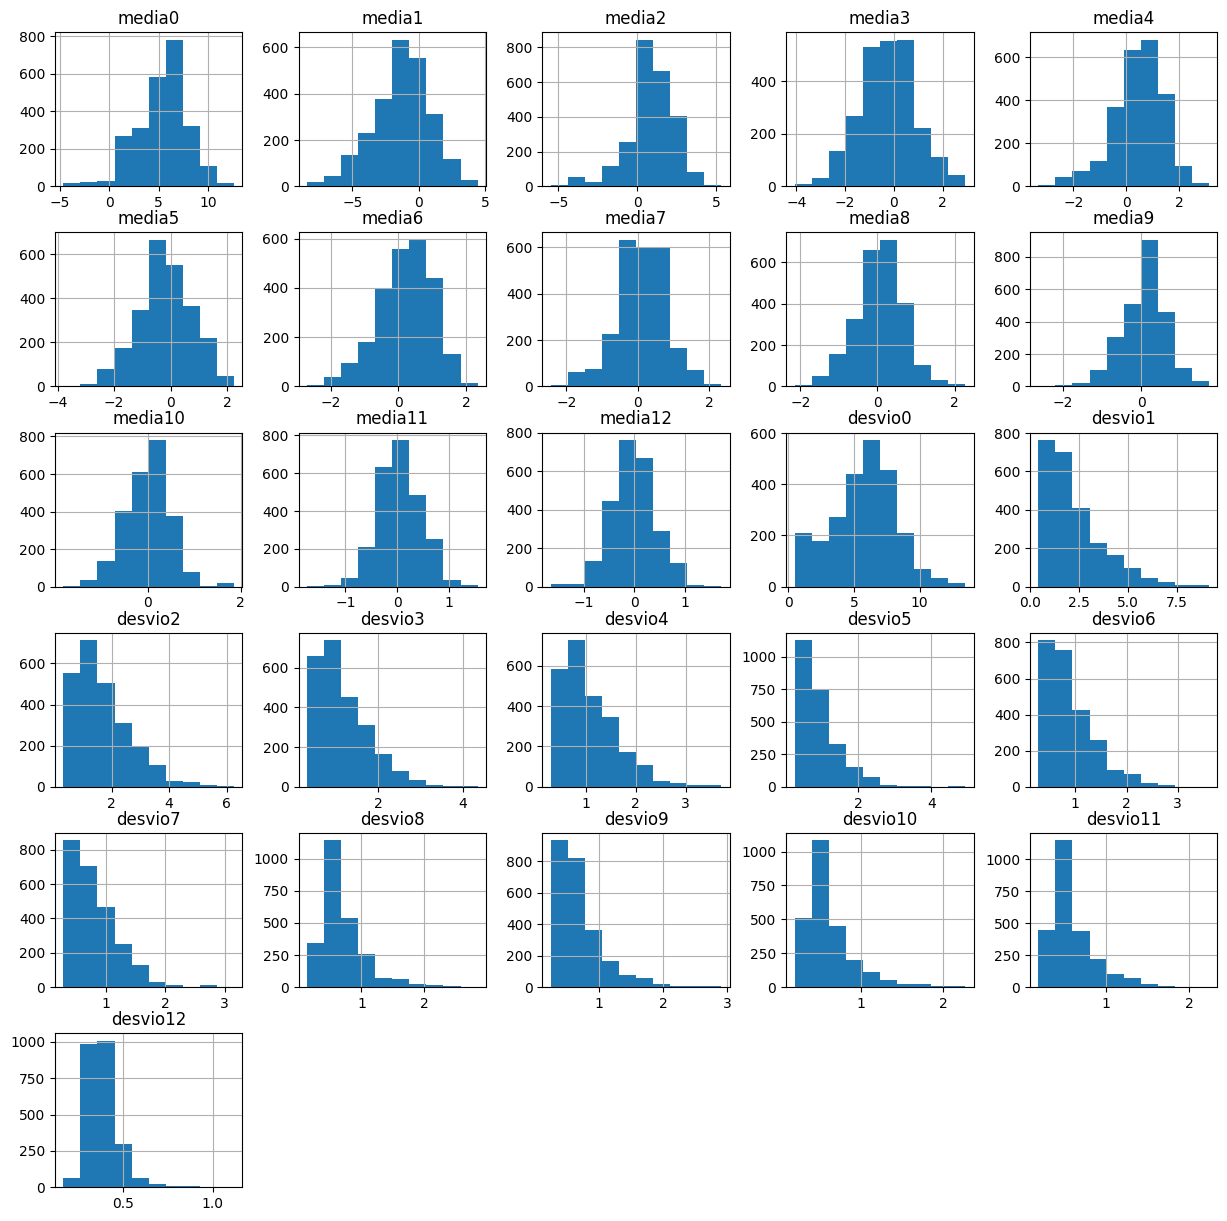

In [8]:
df_merged.hist(figsize=(15,15));

### Comentários...

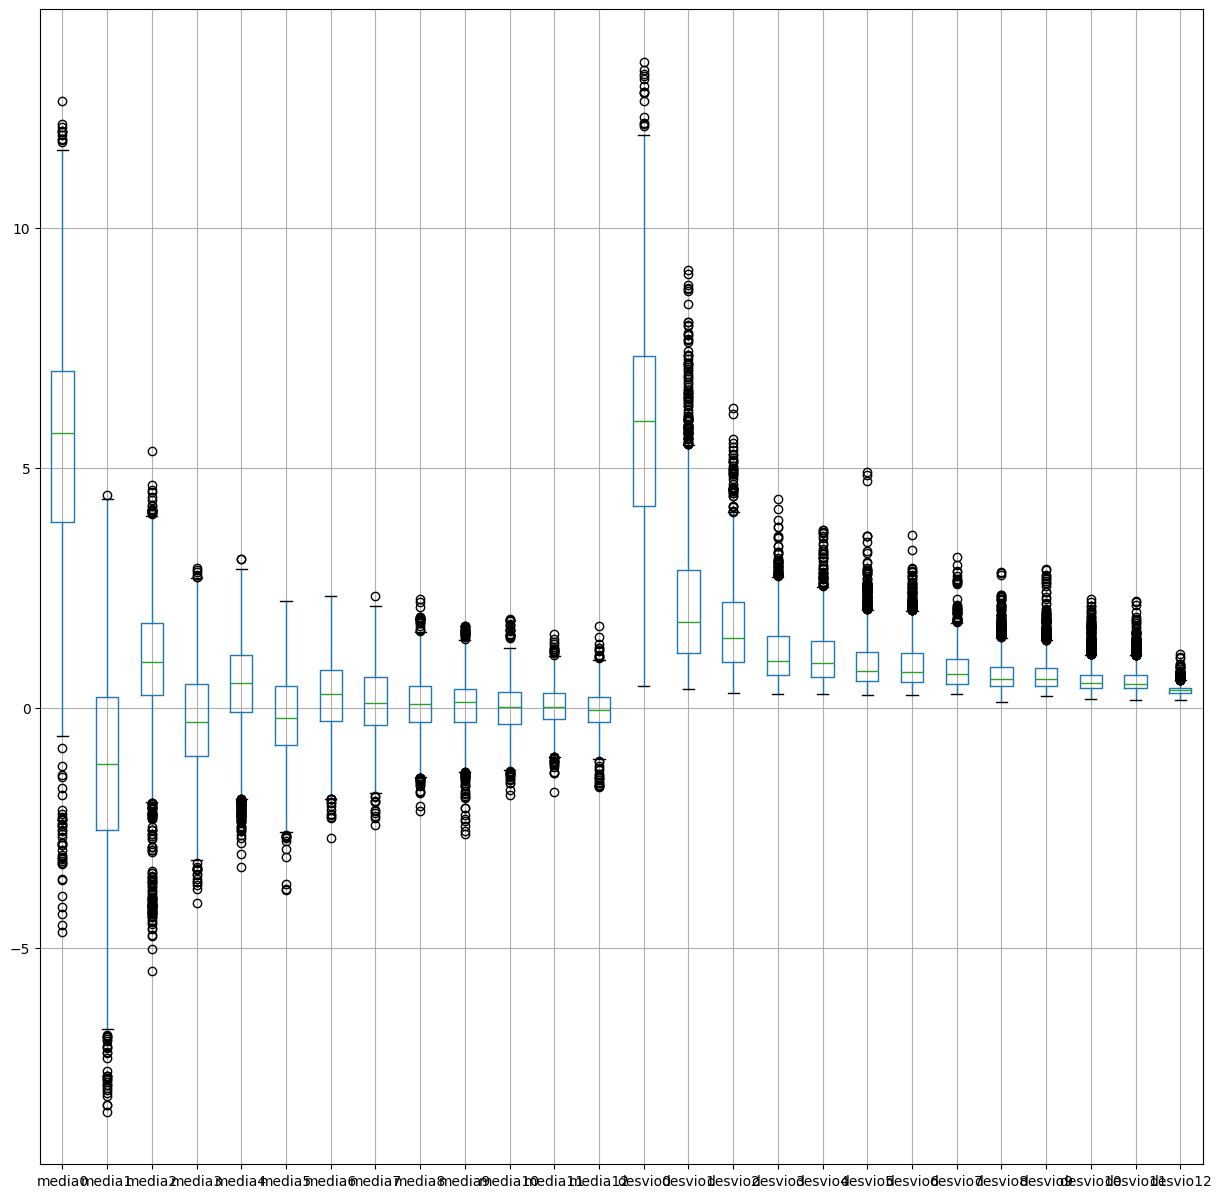

In [9]:
df_merged.boxplot(figsize=(15,15));

### Comentários...

### Analise bivariada
- Scatterplot

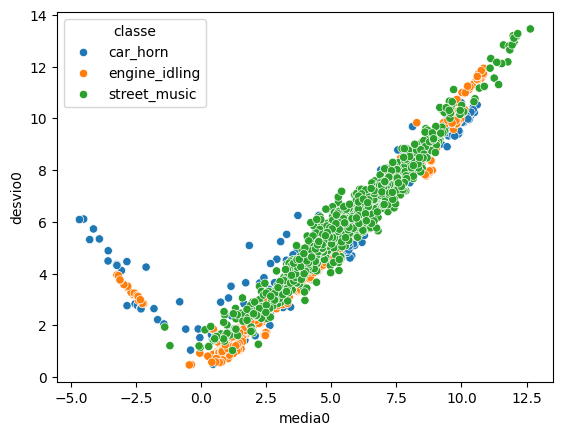

In [10]:
sns.scatterplot(data=df_merged, x='media0', y='desvio0', hue='classe');
plt.show()

### Comentários...

- Heatmap


In [11]:
from scipy.stats import f_oneway

# Get the numerical columns except 'classe'
numerical_columns = df_merged.select_dtypes(include=['number'])

target_column = 'classe'

# Dictionary to store F-statistic and p-value for each column
results = {}

for col in numerical_columns.columns:
    # Group the data by the target variable
    grouped_data = [df_merged[col][df_merged[target_column] == classe] for classe in df_merged[target_column].unique()]
    
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*grouped_data)
    
    # Store results in the dictionary
    results[col] = {'F-statistic': f_statistic, 'p-value': p_value}

# Sort the results by p-value in ascending order
sorted_results = sorted(results.items(), key=lambda x: x[1]['p-value'])

# Print results sorted by p-value
for col, values in sorted_results:
    print(f"Column: {col}, F-statistic: {values['F-statistic']}, p-value: {values['p-value']:.10f}")


Column: media5, F-statistic: 353.9252735912777, p-value: 0.0000000000
Column: desvio12, F-statistic: 353.28313008353405, p-value: 0.0000000000
Column: media1, F-statistic: 290.2235617513166, p-value: 0.0000000000
Column: desvio1, F-statistic: 278.7069159437783, p-value: 0.0000000000
Column: media8, F-statistic: 267.86605255351395, p-value: 0.0000000000
Column: media6, F-statistic: 224.1299289754145, p-value: 0.0000000000
Column: media9, F-statistic: 139.7445656565157, p-value: 0.0000000000
Column: desvio5, F-statistic: 137.30364143061277, p-value: 0.0000000000
Column: media3, F-statistic: 130.62308707416034, p-value: 0.0000000000
Column: media2, F-statistic: 126.10382117454981, p-value: 0.0000000000
Column: media7, F-statistic: 114.84047010772939, p-value: 0.0000000000
Column: media10, F-statistic: 99.70606818478653, p-value: 0.0000000000
Column: media12, F-statistic: 98.47356866242497, p-value: 0.0000000000
Column: desvio3, F-statistic: 76.81739924584281, p-value: 0.0000000000
Column:

##### Aqui podemos verificar a ordem pela qual as colunas deste dataframe têm correlação com a variável alvo.
###### Uma F-statistic alta e um p-value baixo juntos sugerem que as diferenças observadas entre os grupos são provavelmente reais e não apenas devido à variação aleatória, indicando significância estatística. Como tal podemos concluir que as colunas mais relevantes para a variavel alvo são *media5*, *desvio12*, *media1*, *desvio1*, etc.

### Let's start by dividing the data so that we make sure the distribution % is the same between datasets

### Criar um df com 75% dos dados de cada modelo


In [12]:
df_horn_75 = df_horn.sample(frac=0.75, random_state=0)
df_engine_75 = df_engine.sample(frac=0.75, random_state=0)
df_music_75 = df_music.sample(frac=0.75, random_state=0)

df_training = pd.concat([df_horn_75, df_engine_75, df_music_75], ignore_index=True)

### Criar um df com 25% dos dados de cada modelo

In [13]:
df_horn_25 = df_horn.drop(df_horn_75.index)
df_engine_25 = df_engine.drop(df_engine_75.index)
df_music_25 = df_music.drop(df_music_75.index)

df_testing = pd.concat([df_horn_25, df_engine_25, df_music_25], ignore_index=True)

### Let's start with the Logistic Regression Model

In [14]:
model = LogisticRegression(max_iter=1000)

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

# Predict on the testing data
y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.8078175895765473
Confusion Matrix:
 [[ 73  10  24]
 [  4 215  31]
 [ 18  31 208]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.77      0.68      0.72       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.79      0.81      0.80       257

     accuracy                           0.81       614
    macro avg       0.80      0.78      0.79       614
 weighted avg       0.81      0.81      0.81       614



### Now we use cross-validation (k=5 and k=10) , data is already separated into training and testing


In [15]:

#k=5
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.83468835 0.80758808 0.85597826 0.79347826 0.78804348]
0.8159552845528454

K=10
[0.87567568 0.81621622 0.82608696 0.79347826 0.89130435 0.80434783
 0.76630435 0.82608696 0.76630435 0.7826087 ]
0.8148413631022328


### Comentários...

### LOOCV

In [16]:

loo = LeaveOneOut()
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8235613463626493


### Comentários...

### Now we want to use bootstrap

- Prepare bootstrap sample

In [17]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Out of bag observations

In [18]:

oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

### Comentários...

### Now we can move on to LDA

In [19]:
#LDA

model = LinearDiscriminantAnalysis()

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.7915309446254072
Confusion Matrix:
 [[ 72  11  24]
 [  3 213  34]
 [ 16  40 201]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.79      0.67      0.73       107
engine_idling       0.81      0.85      0.83       250
 street_music       0.78      0.78      0.78       257

     accuracy                           0.79       614
    macro avg       0.79      0.77      0.78       614
 weighted avg       0.79      0.79      0.79       614



### Comentários...

### Now we want to apply cross-validation (k=5 and k=10)

In [20]:
#k=5
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.82926829 0.78861789 0.8423913  0.78804348 0.74456522]
0.7985772357723577

K=10
[0.84864865 0.83243243 0.80978261 0.77717391 0.89130435 0.7826087
 0.77173913 0.79347826 0.76630435 0.76630435]
0.8039776733254994


### Now we want to use LOOCV

In [21]:
loo = LeaveOneOut()
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8034744842562432


### Comentários...

### Now we want to use bootstrap

- Prepare bootstrap sample

In [22]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Out of bag observations

In [23]:
oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

### Comentários...

### Let's try the same approach while using QDA

In [24]:
#QDA

model = QuadraticDiscriminantAnalysis()

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.8355048859934854
Confusion Matrix:
 [[ 78   8  21]
 [  2 213  35]
 [ 18  17 222]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.80      0.73      0.76       107
engine_idling       0.89      0.85      0.87       250
 street_music       0.80      0.86      0.83       257

     accuracy                           0.84       614
    macro avg       0.83      0.81      0.82       614
 weighted avg       0.84      0.84      0.84       614



### Comentários...

### Now we want to apply cross-validation (k=5 and k=10) for QDA

In [25]:
#k=5
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.8699187  0.81300813 0.87228261 0.82065217 0.85054348]
0.8452810180275716

K=10
[0.85405405 0.85945946 0.80978261 0.81521739 0.91304348 0.85326087
 0.80978261 0.83695652 0.83152174 0.86413043]
0.8447209165687426


### Comentários...

### Now we use LOOCV for QDA

In [26]:
loo = LeaveOneOut()
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8452768729641694


### Comentários...

### Now we use bootstrap for QDA
- Prepare the bootstrap sample

In [27]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Prepare the out of bag observations

In [28]:

oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

### Comentários...

### Feature Selection

### Lasso

In [29]:
X_train = df_training.drop('classe', axis=1)
y_train = df_training['classe']

X_test = df_testing.drop('classe', axis=1)
y_test = df_testing['classe']

# Create and fit Logistic Regression with L1 regularization (Lasso) on training data
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
log_reg_l1.fit(X_train, y_train)

y_pred_l1 = log_reg_l1.predict(X_test)

accuracy_l1 = accuracy_score(y_test, y_pred_l1)
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)
class_report_l1 = classification_report(y_test, y_pred_l1)

print("L1 Model Metrics:")
print("Accuracy: ", accuracy_l1)
print("Confusion Matrix:\n", conf_matrix_l1)
print("Classification Report:\n", class_report_l1)

# Get coefficients for L1 regularization
coefficients_l1 = log_reg_l1.coef_[0]

# Get the absolute values of coefficients
abs_coefficients_l1 = abs(coefficients_l1)

# Create a dictionary with column names and coefficients
coefficients_dict_l1 = dict(zip(X_train.columns, abs_coefficients_l1))

# Sort the coefficients by their absolute values
sorted_coefficients_l1 = sorted(coefficients_dict_l1.items(), key=lambda x: x[1], reverse=True)

# Print the coefficients in order
print("Coefficients for L1 regularization (by magnitude):")
for feature, coef in sorted_coefficients_l1:
    print(f"{feature}: {coef}")


L1 Model Metrics:
Accuracy:  0.8175895765472313
Confusion Matrix:
 [[ 73  13  21]
 [ 10 215  25]
 [ 15  28 214]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.74      0.68      0.71       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.82      0.83      0.83       257

     accuracy                           0.82       614
    macro avg       0.80      0.79      0.80       614
 weighted avg       0.82      0.82      0.82       614

Coefficients for L1 regularization (by magnitude):
desvio12: 4.5328472838512255
desvio11: 2.395542855193863
desvio8: 1.6465585425800222
media9: 1.6268277571519438
desvio10: 1.483820055944877
media11: 1.414374828007885
media7: 1.3575324244074243
media12: 1.280640762257819
media10: 1.1387460716197584
media8: 1.0548520662810585
desvio5: 0.9891618493007976
media4: 0.8131169281541648
desvio0: 0.780058471016611
media0: 0.7666936096378937
desvio6: 0.6666916174621632
desvio1: 0.

##### Depois de aplicar o Lasso vemos que *media5* perde algum relevo enquanto *desvio12* se mantém no topo da lista no que toca a coeficiente de importância , e podemos ver também que *desvio11* sobe também bastante na lista

### Ridge

In [30]:
# Create and fit Logistic Regression with L2 regularization (Ridge) on training data
log_reg_l2 = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
log_reg_l2.fit(X_train, y_train)

y_pred_l2 = log_reg_l2.predict(X_test)

accuracy_l2 = accuracy_score(y_test, y_pred_l2)
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)
class_report_l2 = classification_report(y_test, y_pred_l2)

print("\nL2 Model Metrics:")
print("Accuracy: ", accuracy_l2)
print("Confusion Matrix:\n", conf_matrix_l2)
print("Classification Report:\n", class_report_l2)

# Get coefficients for L2 regularization
coefficients_l2 = log_reg_l2.coef_[0]

# Get the absolute values of coefficients
abs_coefficients_l2 = abs(coefficients_l2)

# Create a dictionary with column names and coefficients
coefficients_dict_l2 = dict(zip(X_train.columns, abs_coefficients_l2))

# Sort the coefficients by their absolute values
sorted_coefficients_l2 = sorted(coefficients_dict_l2.items(), key=lambda x: x[1], reverse=True)

# Print the coefficients in order
print("Coefficients for L2 regularization (by magnitude):")
for feature, coef in sorted_coefficients_l2:
    print(f"{feature}: {coef}")



L2 Model Metrics:
Accuracy:  0.8078175895765473
Confusion Matrix:
 [[ 73  10  24]
 [  4 215  31]
 [ 18  31 208]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.77      0.68      0.72       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.79      0.81      0.80       257

     accuracy                           0.81       614
    macro avg       0.80      0.78      0.79       614
 weighted avg       0.81      0.81      0.81       614

Coefficients for L2 regularization (by magnitude):
desvio11: 1.5439949332156915
desvio8: 1.2435815734737627
desvio10: 1.2277468372010167
desvio12: 1.1359535576843711
media11: 0.9511327328076749
media9: 0.9503530255519825
media7: 0.8983380547622258
media10: 0.7656184520246971
media12: 0.7520811396335715
media8: 0.7230171037858005
media4: 0.6814667785595228
desvio5: 0.6744495349172163
media0: 0.62568197443184
desvio0: 0.6250514927142092
desvio1: 0.4842820316082422
desvio6

##### Ao aplicar ridge vemos que, novamente, *media5* perde relevo, *desvio11* passa para o topo da lista e *desvio12*, embora desça alguns lugares se mantém como relevante. Até ao momento, a "variável" que se mantém como relevante ao longo dos diferentes testes de correlação é *desvio12*

### Em relação à questão "Can classification models obtain better results if they use just a few features instead of all available features?" podemos verificar que a accuracy e f1-score são melhores (embora muito equiparaveis) apenas do que o obtido anteriormente com LDA.

### Non-linear functions (W.I.P)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train_encoded.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test_encoded.reshape(-1, 1)).flatten()

print("Unique values in y_train_scaled:", np.unique(y_train_scaled))

y_train_binary = np.round(y_train_scaled)
y_test_binary = np.round(y_test_scaled)

# Create and fit Logistic Regression model on training data with binary y data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train_binary)

y_pred_binary = log_reg.predict(X_test)

accuracy_log_reg = accuracy_score(y_test_binary, y_pred_binary)
conf_matrix_log_reg = confusion_matrix(y_test_binary, y_pred_binary)
class_report_log_reg = classification_report(y_test_binary, y_pred_binary)

print("\nLogistic Regression Model Metrics:")
print("Accuracy: ", accuracy_log_reg)
print("Confusion Matrix:\n", conf_matrix_log_reg)
print("Classification Report:\n", class_report_log_reg)


Unique values in y_train_scaled: [0.  0.5 1. ]

Logistic Regression Model Metrics:
Accuracy:  0.8241042345276873
Confusion Matrix:
 [[308  49]
 [ 59 198]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       357
         1.0       0.80      0.77      0.79       257

    accuracy                           0.82       614
   macro avg       0.82      0.82      0.82       614
weighted avg       0.82      0.82      0.82       614



### Comentários...

**Polynomial Regression (OLS Test)** 

In [32]:

train_data = pd.DataFrame(X_train, columns=['media0', 'media1', 'media2', 'media3', 'media4', 'media5', 'media6', 'media7', 'media8', 'media9', 'media10', 'media11', 'media12'])  
train_data['classe'] = y_train_binary

formula = 'classe ~ media0 + media1 + media2 + media3 + media4 + media5 + media6 + media7 + media8 + media9 + media10 + media11 + media12'  

ols_model = smf.ols(formula, data=train_data).fit()

print(ols_model.summary())

# Predict using OLS model on test set
test_data = pd.DataFrame(X_test, columns=['media0', 'media1', 'media2', 'media3', 'media4', 'media5', 'media6', 'media7', 'media8', 'media9', 'media10', 'media11', 'media12'])  
y_pred_ols = ols_model.predict(test_data)

y_pred_ols_binary = np.round(y_pred_ols)

accuracy_ols = accuracy_score(y_test_binary, y_pred_ols_binary)
conf_matrix_ols = confusion_matrix(y_test_binary, y_pred_ols_binary)
class_report_ols = classification_report(y_test_binary, y_pred_ols_binary)

print("\nOLS Model Metrics:")
print("Accuracy: ", accuracy_ols)
print("Confusion Matrix:\n", conf_matrix_ols)
print("Classification Report:\n", class_report_ols)

                            OLS Regression Results                            
Dep. Variable:                 classe   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     59.78
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          2.12e-130
Time:                        17:49:07   Log-Likelihood:                -985.53
No. Observations:                1842   AIC:                             1999.
Df Residuals:                    1828   BIC:                             2076.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3593      0.032     11.304      0.0

### Comentários...

**Predictions**

In [33]:
df_media = df_merged.iloc[:, 0:13].agg(tuple, axis=1) #ToDo: Check later
min_value = df_media.min()
max_value = df_media.max()

simpleTable, data, column_names = summary_table(ols_model, alpha=0.05)
predictions = ols_model.predict(test_data)

predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T

In [34]:
print("Sizes:",len(df_media), len(predicted_mean_ci_low), len(predicted_mean_ci_high))

Sizes: 2456 1842 1842


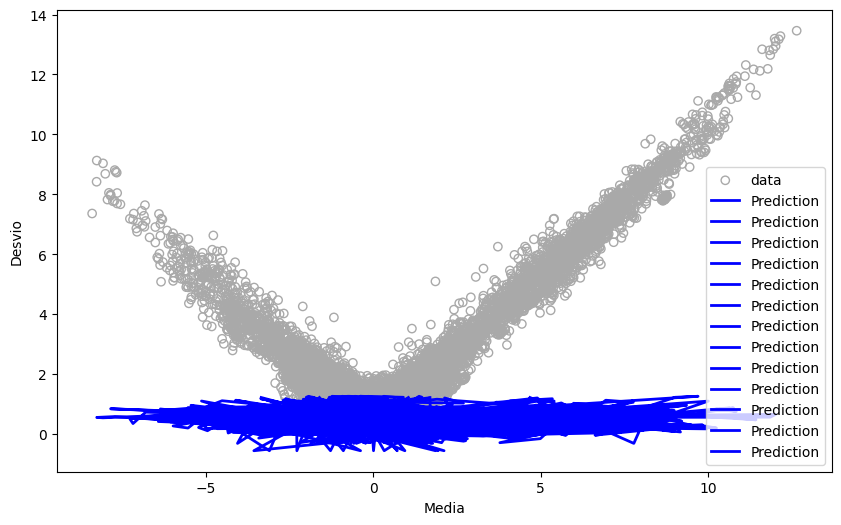

In [35]:
media_columns = df_merged[['media0', 'media1', 'media2', 'media3', 'media4', 'media5', 'media6', 'media7', 'media8', 'media9', 'media10', 'media11', 'media12']]
desvio_columns = df_merged[['desvio0', 'desvio1', 'desvio2', 'desvio3', 'desvio4', 'desvio5', 'desvio6', 'desvio7', 'desvio8', 'desvio9', 'desvio10', 'desvio11', 'desvio12']]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(media_columns.values.flatten(), desvio_columns.values.flatten(), facecolors='none', edgecolors='darkgray', label='data')

# Plot the predictions
ax.plot(test_data, predictions, 'b-', lw=2, label='Prediction')

order = np.argsort(media_columns.values.flatten())
#ax.plot(media_columns.values.flatten()[order], predicted_mean_ci_low[order], 'b--', label='95% CI')
#ax.plot(media_columns.values.flatten()[order], predicted_mean_ci_high[order], 'b--', lw=1)

# Set the labels for the x and y axis
ax.legend(loc='best')
ax.set_xlabel('Media')
ax.set_ylabel('Desvio')

# Show the plot
plt.show()

### Comentários...

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_dt = dt_classifier.predict(X_test)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy_dt)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.8648208469055375
Classification Report:
               precision    recall  f1-score   support

     car_horn       0.75      0.80      0.78       107
engine_idling       0.91      0.90      0.91       250
 street_music       0.87      0.85      0.86       257

     accuracy                           0.86       614
    macro avg       0.84      0.85      0.85       614
 weighted avg       0.87      0.86      0.87       614

Confusion Matrix:
[[ 86   4  17]
 [  8 226  16]
 [ 20  18 219]]


Tuned Model 1 Accuracy: 0.8501628664495114
Tuned Model 2 Accuracy: 0.8338762214983714
Tuned Model 3 Accuracy: 0.8387622149837134
Tuned Model 4 Accuracy: 0.8501628664495114
Tuned Model 5 Accuracy: 0.8436482084690554
Tuned Model 6 Accuracy: 0.8387622149837134
Tuned Model 7 Accuracy: 0.8501628664495114
Tuned Model 8 Accuracy: 0.8566775244299675
Tuned Model 9 Accuracy: 0.8485342019543974


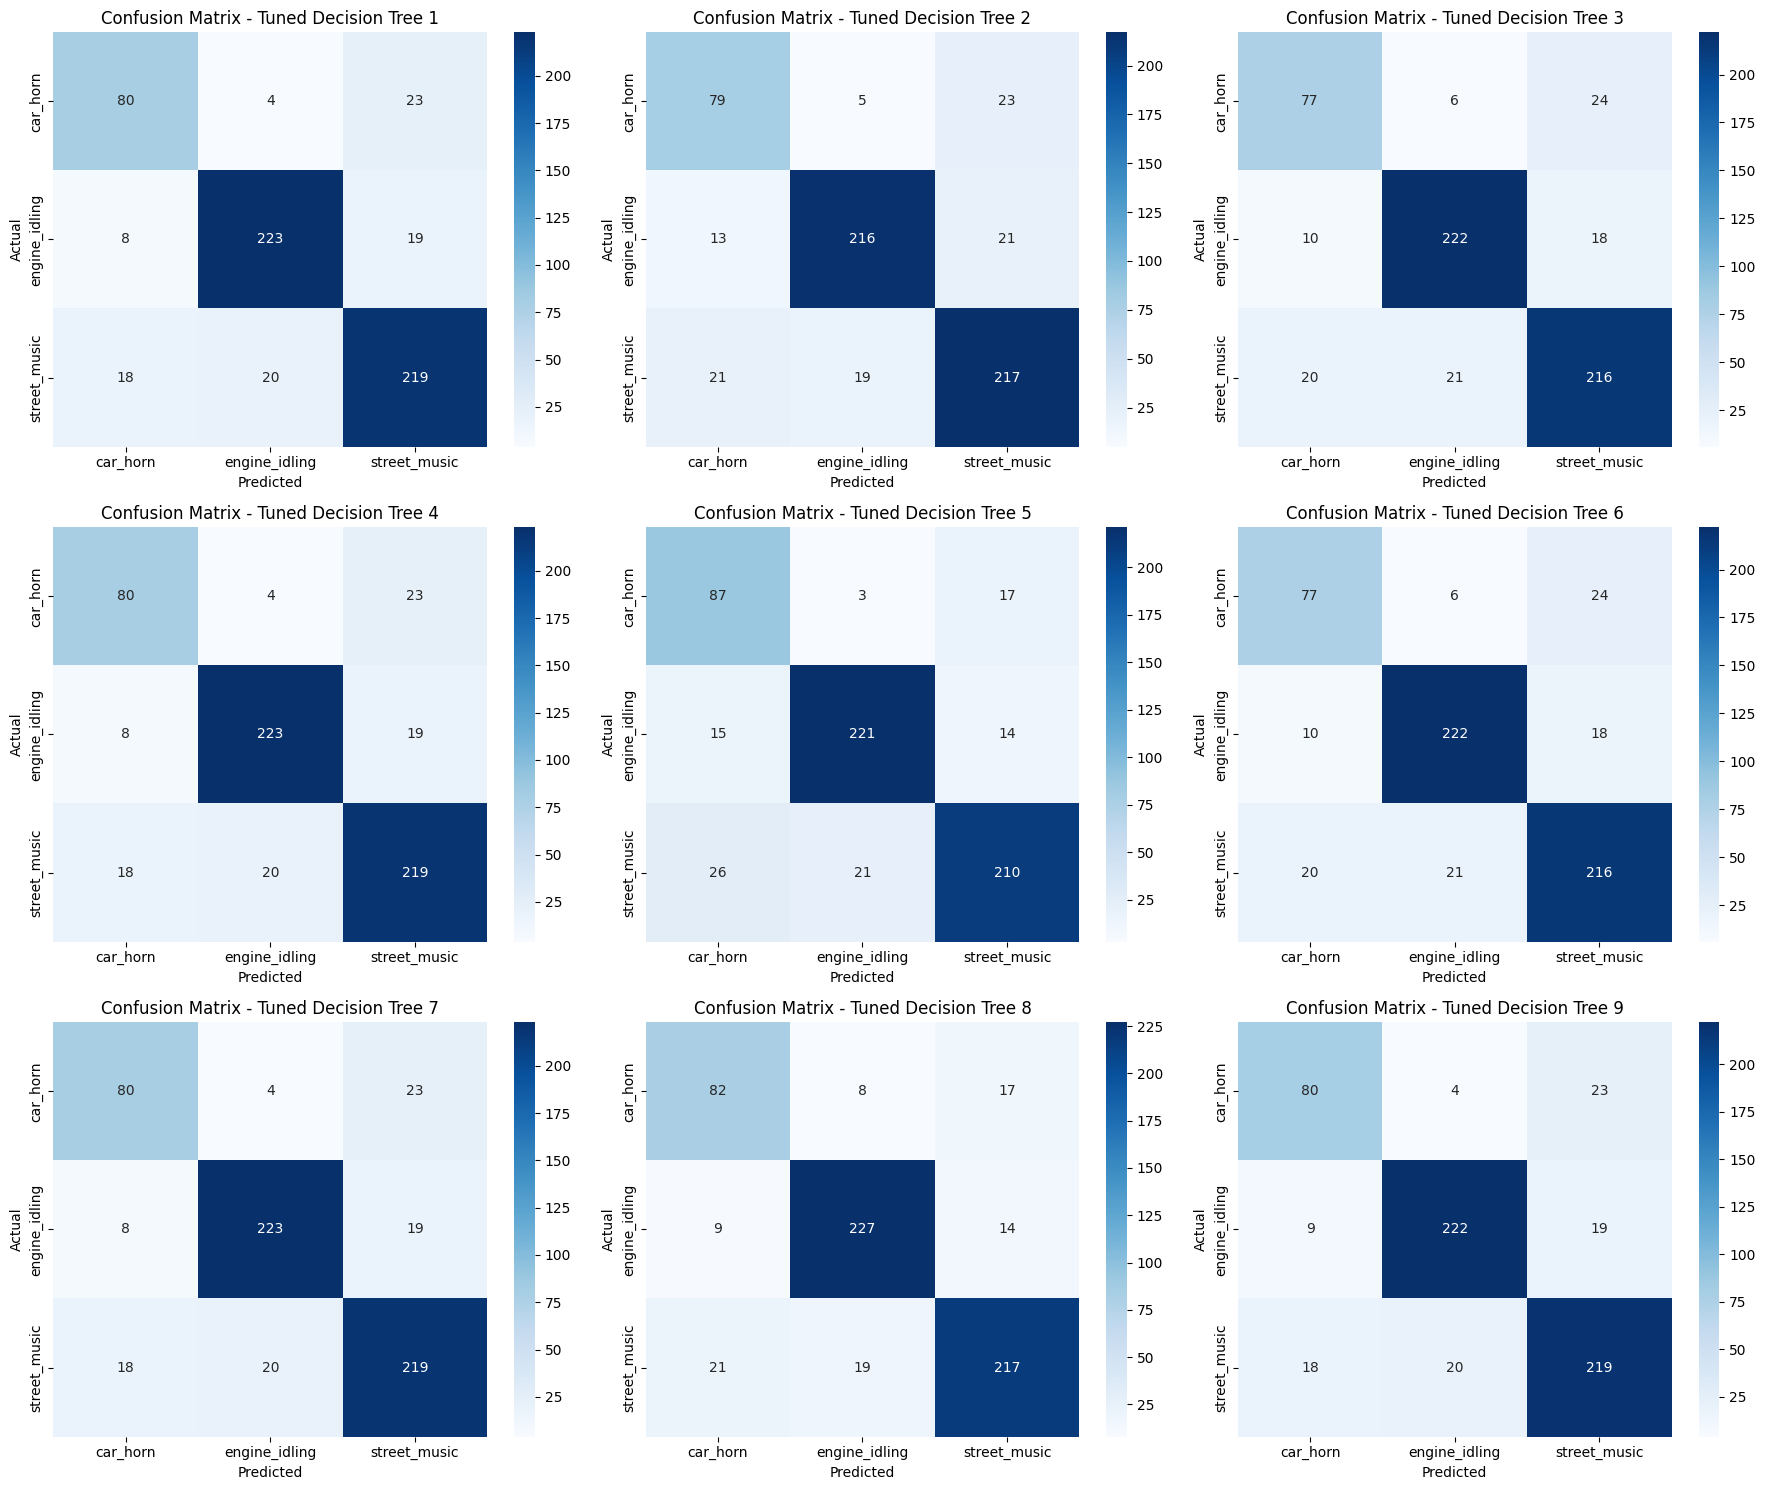

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define nine different sets of values for hyperparameters (the ideal would be 27 sets but that would be to extensive)
# The idea is for each group of 3 parameters to have a different range of values between them, so that we can see how the model performs with different combinations of parameters
# and also to check the influence of each hyperparameter on the model's performance. 
# As such, we will do groups of 3 as mentioned before, while keeping one of the parameters constant and changing the other two.

param_grid_1 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_2 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_3 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [3, 4, 6]
}

param_grid_4 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_5 = {
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_6 = {
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 6]
}

param_grid_7 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_8 = {
    'max_depth': [None, 8, 12],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_9 = {
    'max_depth': [None, 10, 15],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for each set of parameters
grid_dt_1 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_1, cv=5, scoring='accuracy')
grid_dt_2 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_2, cv=5, scoring='accuracy')
grid_dt_3 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_3, cv=5, scoring='accuracy')
grid_dt_4 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_4, cv=5, scoring='accuracy')
grid_dt_5 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_5, cv=5, scoring='accuracy')
grid_dt_6 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_6, cv=5, scoring='accuracy')
grid_dt_7 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_7, cv=5, scoring='accuracy')
grid_dt_8 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_8, cv=5, scoring='accuracy')
grid_dt_9 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_9, cv=5, scoring='accuracy')

# Fit GridSearchCV on training data for each set
grid_dt_1.fit(X_train, y_train)
grid_dt_2.fit(X_train, y_train)
grid_dt_3.fit(X_train, y_train)
grid_dt_4.fit(X_train, y_train)
grid_dt_5.fit(X_train, y_train)
grid_dt_6.fit(X_train, y_train)
grid_dt_7.fit(X_train, y_train)
grid_dt_8.fit(X_train, y_train)
grid_dt_9.fit(X_train, y_train)

# Get best parameters and best estimator for each set
best_params_dt_1 = grid_dt_1.best_params_
best_estimator_dt_1 = grid_dt_1.best_estimator_

best_params_dt_2 = grid_dt_2.best_params_
best_estimator_dt_2 = grid_dt_2.best_estimator_

best_params_dt_3 = grid_dt_3.best_params_
best_estimator_dt_3 = grid_dt_3.best_estimator_

best_params_dt_4 = grid_dt_4.best_params_
best_estimator_dt_4 = grid_dt_4.best_estimator_

best_params_dt_5 = grid_dt_5.best_params_
best_estimator_dt_5 = grid_dt_5.best_estimator_

best_params_dt_6 = grid_dt_6.best_params_
best_estimator_dt_6 = grid_dt_6.best_estimator_

best_params_dt_7 = grid_dt_7.best_params_
best_estimator_dt_7 = grid_dt_7.best_estimator_

best_params_dt_8 = grid_dt_8.best_params_
best_estimator_dt_8 = grid_dt_8.best_estimator_

best_params_dt_9 = grid_dt_9.best_params_
best_estimator_dt_9 = grid_dt_9.best_estimator_

# Use best estimator for predictions for each set
y_pred_dt_tuned_1 = best_estimator_dt_1.predict(X_test)
y_pred_dt_tuned_2 = best_estimator_dt_2.predict(X_test)
y_pred_dt_tuned_3 = best_estimator_dt_3.predict(X_test)
y_pred_dt_tuned_4 = best_estimator_dt_4.predict(X_test)
y_pred_dt_tuned_5 = best_estimator_dt_5.predict(X_test)
y_pred_dt_tuned_6 = best_estimator_dt_6.predict(X_test)
y_pred_dt_tuned_7 = best_estimator_dt_7.predict(X_test)
y_pred_dt_tuned_8 = best_estimator_dt_8.predict(X_test)
y_pred_dt_tuned_9 = best_estimator_dt_9.predict(X_test)

# Evaluate tuned model's performance for each set
accuracy_dt_tuned_1 = accuracy_score(y_test, y_pred_dt_tuned_1)
accuracy_dt_tuned_2 = accuracy_score(y_test, y_pred_dt_tuned_2)
accuracy_dt_tuned_3 = accuracy_score(y_test, y_pred_dt_tuned_3)
accuracy_dt_tuned_4 = accuracy_score(y_test, y_pred_dt_tuned_4)
accuracy_dt_tuned_5 = accuracy_score(y_test, y_pred_dt_tuned_5)
accuracy_dt_tuned_6 = accuracy_score(y_test, y_pred_dt_tuned_6)
accuracy_dt_tuned_7 = accuracy_score(y_test, y_pred_dt_tuned_7)
accuracy_dt_tuned_8 = accuracy_score(y_test, y_pred_dt_tuned_8)
accuracy_dt_tuned_9 = accuracy_score(y_test, y_pred_dt_tuned_9)

print("Tuned Model 1 Accuracy:", accuracy_dt_tuned_1)
print("Tuned Model 2 Accuracy:", accuracy_dt_tuned_2)
print("Tuned Model 3 Accuracy:", accuracy_dt_tuned_3)
print("Tuned Model 4 Accuracy:", accuracy_dt_tuned_4)
print("Tuned Model 5 Accuracy:", accuracy_dt_tuned_5)
print("Tuned Model 6 Accuracy:", accuracy_dt_tuned_6)
print("Tuned Model 7 Accuracy:", accuracy_dt_tuned_7)
print("Tuned Model 8 Accuracy:", accuracy_dt_tuned_8)
print("Tuned Model 9 Accuracy:", accuracy_dt_tuned_9)

# Calculate confusion matrix for each of the tuned models
conf_matrix_dt_1 = confusion_matrix(y_test, y_pred_dt_tuned_1)
conf_matrix_dt_2 = confusion_matrix(y_test, y_pred_dt_tuned_2)
conf_matrix_dt_3 = confusion_matrix(y_test, y_pred_dt_tuned_3)
conf_matrix_dt_4 = confusion_matrix(y_test, y_pred_dt_tuned_4)
conf_matrix_dt_5 = confusion_matrix(y_test, y_pred_dt_tuned_5)
conf_matrix_dt_6 = confusion_matrix(y_test, y_pred_dt_tuned_6)
conf_matrix_dt_7 = confusion_matrix(y_test, y_pred_dt_tuned_7)
conf_matrix_dt_8 = confusion_matrix(y_test, y_pred_dt_tuned_8)
conf_matrix_dt_9 = confusion_matrix(y_test, y_pred_dt_tuned_9)

# Plot confusion matrix heatmaps for each model
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Confusion Matrix 1
sns.heatmap(conf_matrix_dt_1, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_1.classes_, 
            yticklabels=best_estimator_dt_1.classes_, ax=axes[0,0])
axes[0,0].set_title("Confusion Matrix - Tuned Decision Tree 1")
axes[0,0].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")

# Confusion Matrix 2
sns.heatmap(conf_matrix_dt_2, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_2.classes_, 
            yticklabels=best_estimator_dt_2.classes_, ax=axes[0,1])
axes[0,1].set_title("Confusion Matrix - Tuned Decision Tree 2")
axes[0,1].set_xlabel("Predicted")
axes[0,1].set_ylabel("Actual")

# Confusion Matrix 3
sns.heatmap(conf_matrix_dt_3, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_3.classes_, 
            yticklabels=best_estimator_dt_3.classes_, ax=axes[0,2])
axes[0,2].set_title("Confusion Matrix - Tuned Decision Tree 3")
axes[0,2].set_xlabel("Predicted")
axes[0,2].set_ylabel("Actual")

# Confusion Matrix 4
sns.heatmap(conf_matrix_dt_4, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_4.classes_, 
            yticklabels=best_estimator_dt_4.classes_, ax=axes[1,0])
axes[1,0].set_title("Confusion Matrix - Tuned Decision Tree 4")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("Actual")

# Confusion Matrix 5
sns.heatmap(conf_matrix_dt_5, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_5.classes_, 
            yticklabels=best_estimator_dt_5.classes_, ax=axes[1,1])
axes[1,1].set_title("Confusion Matrix - Tuned Decision Tree 5")
axes[1,1].set_xlabel("Predicted")
axes[1,1].set_ylabel("Actual")

# Confusion Matrix 6
sns.heatmap(conf_matrix_dt_6, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_6.classes_, 
            yticklabels=best_estimator_dt_6.classes_, ax=axes[1,2])
axes[1,2].set_title("Confusion Matrix - Tuned Decision Tree 6")
axes[1,2].set_xlabel("Predicted")
axes[1,2].set_ylabel("Actual")

# Confusion Matrix 7
sns.heatmap(conf_matrix_dt_7, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_7.classes_, 
            yticklabels=best_estimator_dt_7.classes_, ax=axes[2,0])
axes[2,0].set_title("Confusion Matrix - Tuned Decision Tree 7")
axes[2,0].set_xlabel("Predicted")
axes[2,0].set_ylabel("Actual")

# Confusion Matrix 8
sns.heatmap(conf_matrix_dt_8, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_8.classes_, 
            yticklabels=best_estimator_dt_8.classes_, ax=axes[2,1])
axes[2,1].set_title("Confusion Matrix - Tuned Decision Tree 8")
axes[2,1].set_xlabel("Predicted")
axes[2,1].set_ylabel("Actual")

# Confusion Matrix 9
sns.heatmap(conf_matrix_dt_9, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_9.classes_, 
            yticklabels=best_estimator_dt_9.classes_, ax=axes[2,2])
axes[2,2].set_title("Confusion Matrix - Tuned Decision Tree 9")
axes[2,2].set_xlabel("Predicted")
axes[2,2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

### By checking the results we can see that when we keep the minimum number of samples required to be at a leaf node constant the results tend to stick really close so we can assume it has the most influence, followed by  the minimum number of samples required to split an internal node and then the maximum depth of the tree.

### Now we can also try using RandomTrees

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Assuming 'X' contains the features and 'y' contains the target variable

# Create an instance of RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", accuracy)

# Assuming rf_model is your trained Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9299674267100977
Random Forest Classification Report:
               precision    recall  f1-score   support

     car_horn       0.94      0.78      0.85       107
engine_idling       0.93      0.98      0.95       250
 street_music       0.92      0.95      0.94       257

     accuracy                           0.93       614
    macro avg       0.93      0.90      0.91       614
 weighted avg       0.93      0.93      0.93       614



In [39]:
# Assuming rf_model is your trained Random Forest model and X_train is your DataFrame of features
feature_importance = rf_model.feature_importances_

# Combine with column names and create a DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the values by Importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the ordered list of features and their importances
print(importance_df)

     Feature  Importance
25  desvio12    0.124355
6     media6    0.077505
8     media8    0.062631
5     media5    0.061102
7     media7    0.056616
14   desvio1    0.054217
1     media1    0.052185
9     media9    0.038858
2     media2    0.037561
13   desvio0    0.036796
3     media3    0.035837
12   media12    0.034746
4     media4    0.032531
11   media11    0.029378
0     media0    0.028311
18   desvio5    0.026311
22   desvio9    0.022953
21   desvio8    0.022662
10   media10    0.022658
23  desvio10    0.022293
16   desvio3    0.021633
15   desvio2    0.021286
24  desvio11    0.020690
17   desvio4    0.020035
19   desvio6    0.019892
20   desvio7    0.016957


### Let's try to use some different hyperparameters to check the fluctuation of results

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid for each model
param_grid_1 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_2 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 8, 12],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_3 = {
    'n_estimators': [75, 125, 175],
    'max_depth': [None, 10, 15],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [3, 4, 6]
}

# Initialize GridSearchCV for each set of parameters
grid_search_1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_1,
                             cv=5,
                             scoring='accuracy')

grid_search_2 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_2,
                             cv=5,
                             scoring='accuracy')

grid_search_3 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_3,
                             cv=5,
                             scoring='accuracy')

# Fit the grid searches to the data
grid_search_1.fit(X_train, y_train)
grid_search_2.fit(X_train, y_train)
grid_search_3.fit(X_train, y_train)

# Get the best parameters and best estimators for each set
best_estimator_1 = grid_search_1.best_estimator_
best_estimator_2 = grid_search_2.best_estimator_
best_estimator_3 = grid_search_3.best_estimator_

# Use the best estimators for predictions
y_pred_1 = best_estimator_1.predict(X_test)
y_pred_2 = best_estimator_2.predict(X_test)
y_pred_3 = best_estimator_3.predict(X_test)

# Evaluate the tuned models' performance
accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_2 = accuracy_score(y_test, y_pred_2)
accuracy_3 = accuracy_score(y_test, y_pred_3)

print("Tuned Model 1 Accuracy:", accuracy_1)
print("Tuned Model 2 Accuracy:", accuracy_2)
print("Tuned Model 3 Accuracy:", accuracy_3)

# Calculate feature importances for each model
feature_importance_1 = best_estimator_1.feature_importances_
feature_importance_2 = best_estimator_2.feature_importances_
feature_importance_3 = best_estimator_3.feature_importances_

# Zip feature names and their importances for each model
features_importance_1 = list(zip(X_train.columns, feature_importance_1))
features_importance_2 = list(zip(X_train.columns, feature_importance_2))
features_importance_3 = list(zip(X_train.columns, feature_importance_3))

# Sort features by importance for each model
sorted_features_1 = sorted(features_importance_1, key=lambda x: x[1], reverse=True)
sorted_features_2 = sorted(features_importance_2, key=lambda x: x[1], reverse=True)
sorted_features_3 = sorted(features_importance_3, key=lambda x: x[1], reverse=True)

# Print sorted features by importance for each model
print("\nSorted Feature Importance for Model 1:")
for feature_name, importance in sorted_features_1:
    print(f"{feature_name}: {importance}")

print("\nSorted Feature Importance for Model 2:")
for feature_name, importance in sorted_features_2:
    print(f"{feature_name}: {importance}")

print("\nSorted Feature Importance for Model 3:")
for feature_name, importance in sorted_features_3:
    print(f"{feature_name}: {importance}")

Tuned Model 1 Accuracy: 0.9332247557003257
Tuned Model 2 Accuracy: 0.9185667752442996
Tuned Model 3 Accuracy: 0.9185667752442996

Sorted Feature Importance for Model 1:
desvio12: 0.12564070866001975
media6: 0.07704750135730168
media8: 0.0625649653507199
media5: 0.05994193896410613
media7: 0.058688724650478266
desvio1: 0.05698164593235824
media1: 0.050178433147741085
media9: 0.03902560261408745
desvio0: 0.03843349968066912
media3: 0.037026829486502384
media2: 0.036791957809188
media12: 0.03454449814663204
media4: 0.031095995053253316
media11: 0.0298881806104845
media0: 0.027039117372440292
desvio5: 0.026092244315052256
desvio10: 0.02198991970668236
desvio8: 0.021922788097357118
desvio2: 0.021906555213692717
media10: 0.02168470580423868
desvio3: 0.021630927890027074
desvio9: 0.021161930534607337
desvio11: 0.020577935266739362
desvio4: 0.020178901415427778
desvio6: 0.01955957290035026
desvio7: 0.018404920019843007

Sorted Feature Importance for Model 2:
desvio12: 0.12625644155980675
media

###### Depois destas alterações aos hyperparameters podemos mais uma vez ver a correlação de *desvio12* com a variável alvo. Comparativamente aos resultados obtidos no passo 2 e 4 podemos ver que a accuracy é substancialmente mais alta enquanto mantém *desvio12* se mantém como a varíavel mais relevante do conjunto.

### PCA -  O PCA é sensível às variações de escala das características, por isso vamos padronizar os dados para terem média zero e variância unitária.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a copy of df_training and df_testing
df_training_std = df_training.copy().drop('classe', axis=1)
df_testing_std = df_testing.copy().drop('classe', axis=1)

# Select columns to standardize
columns_to_standardize = df_training_std.columns

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize both training and testing data using the same scaler
df_training_std[columns_to_standardize] = scaler.fit_transform(df_training_std[columns_to_standardize])
df_testing_std[columns_to_standardize] = scaler.transform(df_testing_std[columns_to_standardize])

# Apply PCA to the standardized training data
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca.fit(df_training_std)

# Transform both training and testing data using PCA
df_training_pca = pca.transform(df_training_std)
df_testing_pca = pca.transform(df_testing_std)

# Assuming you have labels for your training and testing data (replace y_train and y_test accordingly)
# Fit a logistic regression model on the transformed training data
model = LogisticRegression()
model.fit(df_training_pca, y_train)

# Predict on the transformed testing data
y_pred = model.predict(df_testing_pca)

# Assess model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

# Get absolute loading scores from PCA components
absolute_loading_scores = np.abs(pca.components_)

# Calculate mean absolute loading scores across principal components
mean_loading_scores = absolute_loading_scores.mean(axis=0)

# Create a DataFrame with mean loading scores for each feature
mean_loading_df = pd.DataFrame(mean_loading_scores, index=df_training_std.columns, columns=['Mean Loading Score'])

# Sort features by mean loading scores in descending order
sorted_features = mean_loading_df.sort_values(by='Mean Loading Score', ascending=False)

# Display sorted features by mean loading scores
print(sorted_features)


Accuracy: 0.8013029315960912
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.75      0.67      0.71       107
engine_idling       0.82      0.84      0.83       250
 street_music       0.80      0.81      0.81       257

     accuracy                           0.80       614
    macro avg       0.79      0.78      0.78       614
 weighted avg       0.80      0.80      0.80       614

          Mean Loading Score
desvio11            0.182400
desvio2             0.180543
desvio3             0.179755
desvio5             0.178822
media8              0.174852
media3              0.174796
desvio8             0.174220
media2              0.169376
desvio12            0.168160
desvio6             0.165808
media12             0.164769
media9              0.164125
media6              0.164003
media5              0.162912
desvio10            0.159972
media7              0.157968
media4              0.151369
media11             0.149615
desvio7 

##### Ao obter estes resultados vemos que *desvio11* volta a ter mais relevância e a aparecer no topo da lista de correlação tendo em conta o loading score. Embora perca algumas "posições" *desvio12* continua a mostrar a relevância que tem visto que o loading score não é consideravelmente diferente do de *desvio11* e a mesma lógica é visível entre *desvio12* e *media5*.

Ao comparar com os resultados obtidos no passo 4 podemos ver que comparando a Lasso o feature mais importante é o mesmo (*desvio11*) e consequentemente, ao comparar ao ridge, tendo em conta que para este último modelo *desvio11* aparece como o 2º feature mais relevante podemos concluir que o PCA obteve resultados similares relativamente à feature mais importante e um pouco diferentes (embora nada muito relevante) relativamente às diferentes features; isto é, a ordem de importância altera-se ligeiramente, dando uma sensação de que os modelos concordam na feature mais importante e "de forma geral" naqueles que consideram mais importantes, intercalando as suas posições entre modelos.
No que toca à accuracy dos modelos, todos eles obtém resultados muito equiparáveis, sendo que o Lasso obteve um valor ligeiramente mais alto (praticamente 0.1)